In [1]:
from cognite.client import CogniteClient
from getpass import getpass
project = "publicdata"
api_url = f"/api/playground/projects/{project}/context/pnidobjects"
c = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "),
                       project=project, client_name="pnid demo")

Open Industrial Data API-KEY:  ················································


## Import utils for demo purpose only

In [2]:
!pip install pdf2image
!pip install bounding-box
from PIL import Image
import numpy as np
import os
from pdf2image import convert_from_path
from bounding_box import bounding_box as bb
import json
import time
import pprint
pp = pprint.PrettyPrinter(indent=2)
label2color = {
    "valve":"navy",
    "indicator":"lime",
    "shared indicator":"red",
    "ball valve":"black",
    "E":"silver",
    "F":"yello",
    "tag":"teal",
    "H":"fuchsia"}

def draw_bbox(pnid_img, result):
    img_arr = np.array(pnid_img)
    height, width = img_arr.shape[:-1]
    img_arr_copy = img_arr[:,:,::-1].copy()
    for obj in result:
        bbox = obj["boundingBox"]
        label = obj["type"]
        color = label2color[label]
        bb.add(
            img_arr_copy,
            int(bbox["xMin"]*width), 
            int(bbox["yMin"]*height),
            int(bbox["xMax"]*width),
            int(bbox["yMax"]*height),
            label,
            color
        )
    return Image.fromarray(img_arr_copy[:,:,::-1])

Processing ./.cache/pip/wheels/0f/80/3a/fac1dc0f7dbe12c805b9dc6497f325f0e9f9cedbec3ab0185b/pdf2image-1.12.1-cp37-none-any.whl
Processing ./.cache/pip/wheels/6a/6b/da/71d602e245ef4e78132ddf9b1fe445aca0f834d9216768a818/bounding_box-0.1.3-cp37-none-any.whl
  Using cached opencv_python-4.2.0.32-cp37-cp37m-manylinux1_x86_64.whl (28.2 MB)


## Download the P&ID to visualize

In [3]:
file_id = 3166289343343820
res = c.files.retrieve(id=file_id)
print(res.name)
c.files.download_to_path(f"./{res.name}.pdf", id=res.id)

PH-ME-P-0156-001


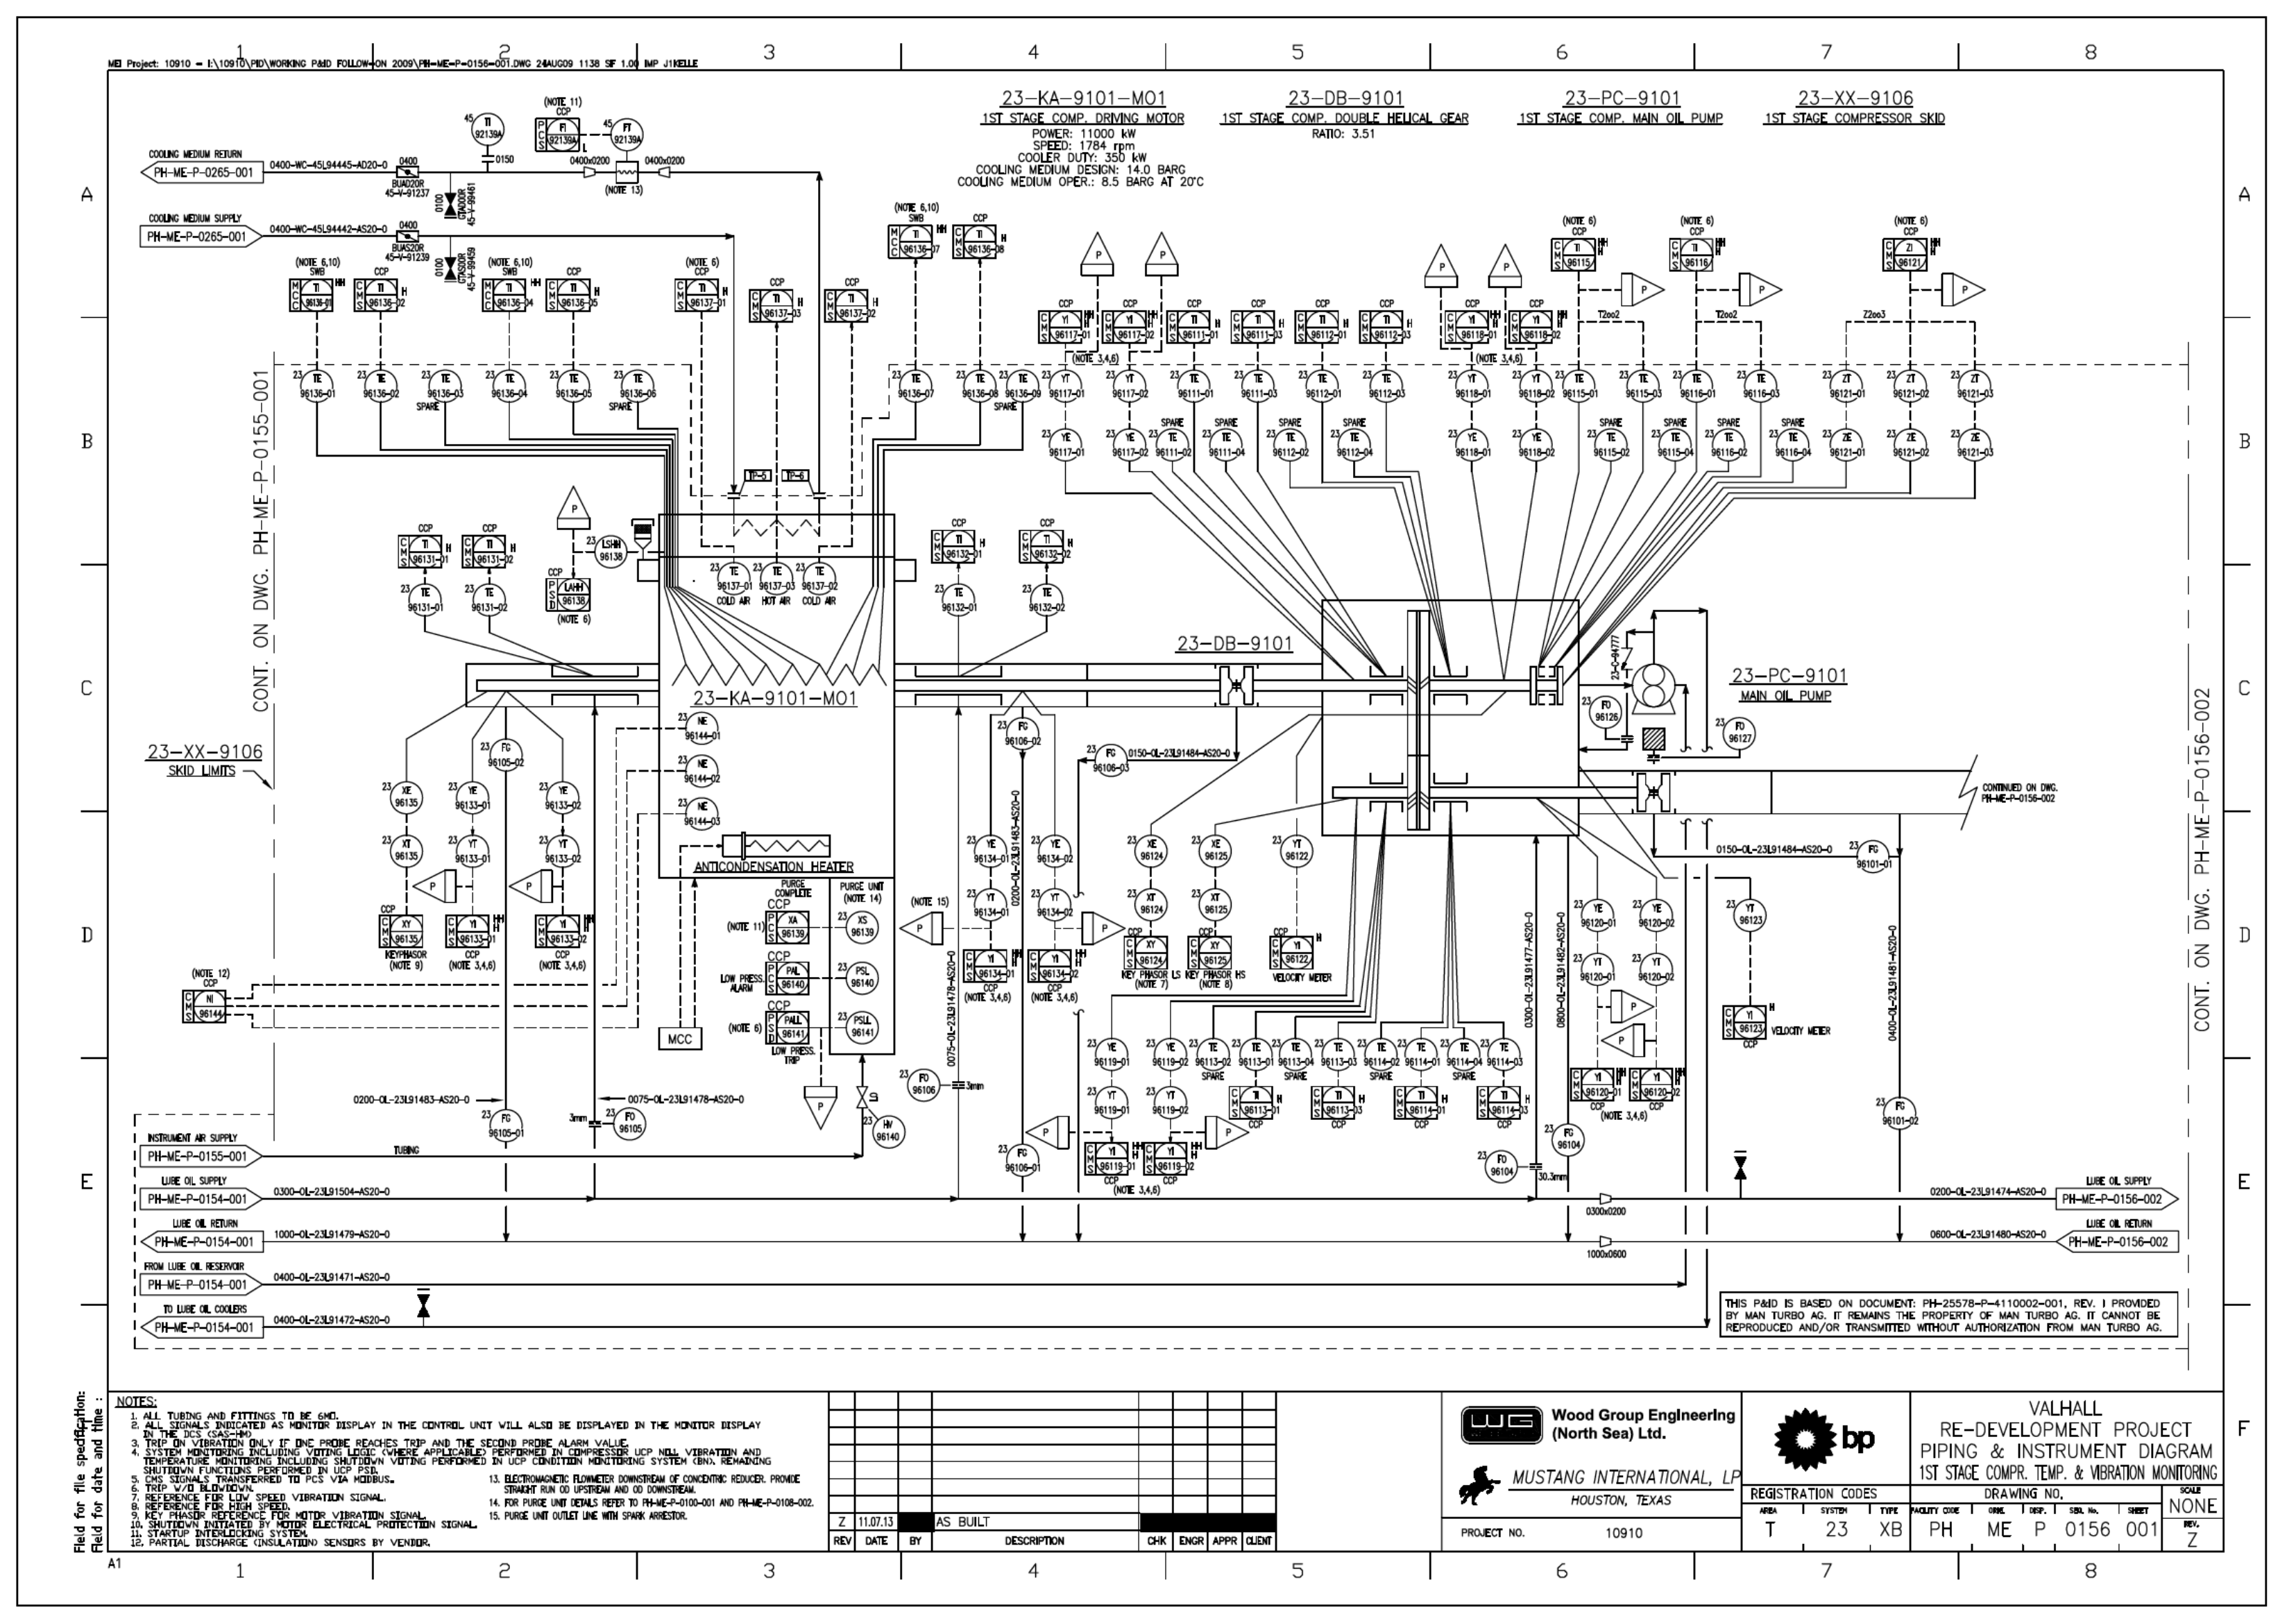

In [4]:
pnid_img = convert_from_path(f"./{res.name}")[0]
pnid_img

## /findobjects endpoint

In [5]:
findobjects_url = f"{api_url}/findobjects"
post_body = {"fileId": file_id}
res = c.post(url = findobjects_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

jobId: 3176026037068541


In [ ]:
%%time
res = c.get(url = f"{api_url}/{job_id}")

while json.loads(res.text)["status"] != "Completed":
    time.sleep(5)
    res = c.get(url = f"{api_url}/{job_id}")


result = json.loads(res.text)["items"]
print(f"found {len(result)} objects")
print("The first object parameters:")
pp.pprint(result[0])

In [ ]:
draw_bbox(pnid_img, result)

## /findsimilar endpoint

In [ ]:
template ={
    'boundingBox': {
        'xMax': 0.5839555757026292,
        'xMin': 0.5684496826835902,
        'yMax': 0.2116289012398461,
        'yMin': 0.1911073108165883},
    'type': 'shared indicator'}
x_max, x_min, y_max, y_min = template["boundingBox"].values()
width, height = pnid_img.size
pnid_img.crop((
    int(x_min*width),
    int(y_min*height),
    int(x_max*width),
    int(y_max*height)
))

In [ ]:
findsimilar_url = f"{api_url}/findsimilar"
post_body = {
    "fileId": file_id,
    "template": template
}
res = c.post(url = findsimilar_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

In [ ]:
%%time
res = c.get(url = f"{api_url}/{job_id}")

while json.loads(res.text)["status"] != "Completed":
    time.sleep(2)
    res = c.get(url = f"{api_url}/{job_id}")
    
result = json.loads(res.text)["items"]
print(f"found {len(result)} objects")

In [ ]:
draw_bbox(pnid_img, result)